## Setup The Envirenement:


## Overview:

the goal of this competition is the predict how small molecules change gene expression in different cell types.


## Exploitation Data Analysis:

In [2]:
# import packages
import sys
if not sys.warnoptions:
    import warnings
    warnings.filterwarnings('ignore')
import numpy as np
import numba as nb
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

####==============> import pylimma
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.losses import Loss
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
# loading the data
df = pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


Text(0.5, 1.0, 'Distribution of cell_type')

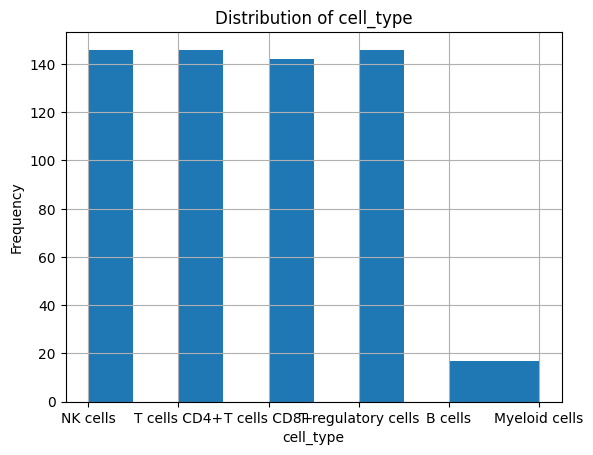

In [4]:
df['cell_type'].hist()
plt.xlabel('cell_type')
plt.ylabel('Frequency')
plt.title('Distribution of cell_type')

In [5]:
from sklearn.cluster import KMeans

## Data Preparation:

In [6]:
X=pd.DataFrame(index=df['sm_name'])
X

""
sm_name
Clotrimazole
Clotrimazole
Clotrimazole
Clotrimazole
Mometasone Furoate
...
Atorvastatin
Riociguat
Riociguat


In [7]:
# encoding the data
encoding=LabelEncoder()
# create an instance for LabelEncoder
for column in ['cell_type', 'sm_name', 'sm_lincs_id',  'SMILES', 'control']:
    df[column]=encoding.fit_transform(df[column])
    #df[column]=df[column]/df[column].abs().max()
df

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,2,39,131,101,0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,3,39,131,101,0,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,4,39,131,101,0,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,5,39,131,101,0,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,2,84,65,81,0,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,5,14,136,21,0,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,2,116,103,53,0,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,3,116,103,53,0,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,4,116,103,53,0,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


## Separating feature and target variables:

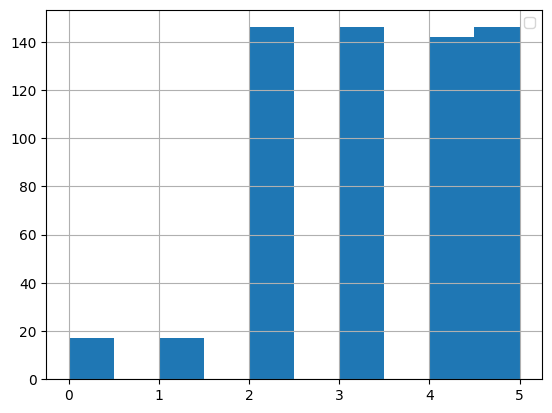

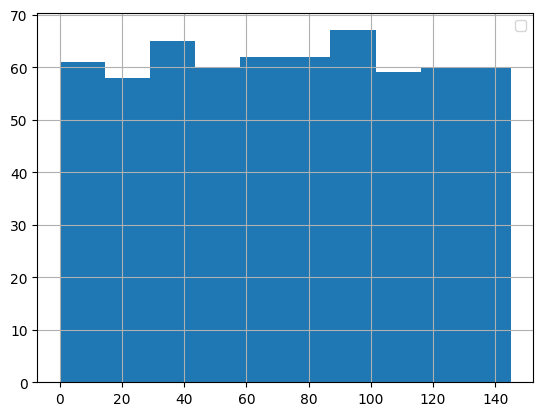

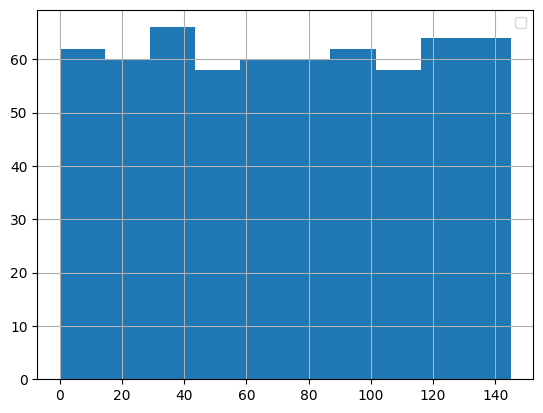

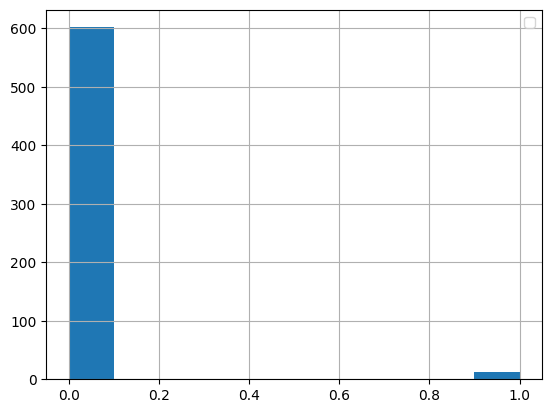

In [8]:
X_train , y_train=df.iloc[:, :2], df.iloc[:, 5:]
X_train 
features=['cell_type', 'sm_name', 'sm_lincs_id', 'control']
for feature in features:
    df[feature].hist()
    plt.legend()
    plt.show()


##  Splitting data into features variables (X_train) and target variables (y_train):

In [9]:
def mrrse(y_pred, y_true):
    return ((y_pred-y_true)**2).mean(axis=1).apply(np.sqrt).mean()

In [10]:
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred=lin_reg.predict(X_train)
print( mrrse(y_train, y_pred))

1.350489314811541


In [11]:
rand_for_reg=RandomForestRegressor()
rand_for_reg.fit(X_train, y_train)
y_pred=rand_for_reg.predict(X_train)

In [12]:
print(mrrse(y_train, y_pred))

0.5625568472800944


## Preparing The Data:

In [13]:
# group by the drug and take the means:
df_simple=df.iloc[:,  [1]+list(range(5, df.shape[1]))]
df_simple

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,39,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,39,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,39,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,39,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,84,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,14,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,116,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,116,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,116,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [14]:
mean_df=df_simple.groupby('sm_name').mean().reset_index()
display(mean_df)

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,141,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
142,142,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
143,143,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
144,144,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


## create a submission file


## Linear Limma model:

In [15]:
# Load in ID map
temp_path = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_ids = pd.read_csv(temp_path)
print(df_ids.shape)
display(df_ids)

(255, 3)


,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


In [16]:
# Load in ID map
temp_path = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_ids = pd.read_csv(temp_path)
print(df_ids.shape)
display(df_ids)

# Load in the sample template 
temp_path = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
submit_df = pd.read_csv(temp_path)
print(submit_df.shape)
display(submit_df)

(255, 3)


,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


(255, 18212)


,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253,253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## List to Store The Filtred Rows:


In [17]:
# List to store the filtered rows
filtered_rows = []

for variable_name in df_ids['sm_name']:
    matching_rows = mean_df[mean_df['sm_name'] == variable_name].copy()
    matching_rows['variable_name'] = variable_name  # Add the additional column indicating the variable_name
    filtered_rows.append(matching_rows)

# Concatenate all filtered rows into a single DataFrame
result_df = pd.concat(filtered_rows)
result_df = result_df.reset_index(drop=True)
result_df

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,variable_name


the $Limma$  model are giveen by the following :

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $f(g_{j})=w_{0}+w_{1}c_{i}+w_{2}l_{i}+w_{3}d_{i}+w_{4}p_{i}+w_{5}t_{i}$

where $f(g_{j})$ is indicator of each gene, and $c_{i}, l_{i}, d_{i}, p_{i}, t_{i}$ are respectively indicators of the compound, library, donor, plate, and cell type of observations.

## Grouping The data:

firstly we downloading all files :

## Implementing Limma model:

In [18]:
id_map = pd.read_csv('/kaggle/input/open-problems-single-cell-perturbations/id_map.csv')
id_map.head()

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


In [ ]:
import pandas as pd
adata_train = pd.read_parquet('/kaggle/input/open-problems-single-cell-perturbations/adata_train.parquet').sample(frac=.1)
adata_train.head()

In [ ]:
multiome_obs_meta = pd.read_csv('/kaggle/input/open-problems-single-cell-perturbations/multiome_obs_meta.csv')
multiome_obs_meta.head()

In [ ]:
class Limma:
    
    def __init__(self, c=None, l=None, d=None, d=None, t=None):
        self.c=c
        self.l=l
        self.d=d
        self.t=t
        
    def fit(self, X_train, y_train):
        pass
    
    def predict(self, X_test):
        pass  

In [ ]:
from keras.models import Sequential
from keras.layers import Input
## Define a linear keras model:
def build_model():
    
    '''
    in keras API : there is three way to define a model:
    1==>: by Sequential keras API: for simple stack model
    2==>: by Functional keras API using the Model class for more
    sophiscated architectures(concatenate layers , combining multiple architecture)
    it's mostly suitable for any architectures(about 95%)
    3==>: by subclass keras API : if you like low level programming and gain more flexibilty
    you can create you own model class that inherit from the parent class keras.layers.Layer
    the price of flexibility is create your own fit (train ) method and that can lead to low performance, 
    slow down your code, bugs, so anyway this method is not preferable if you have other previous choice
    under your sleve.
    '''
    
    model=Sequential()
    model.add(Input(shape=(None, 614, 2)))
    model.add(Dense(12, activation=LeakyReLU()))
    model.add(Dense(y_train.shape[1], activation=LeakyReLU()))
    
    # compile the model
    model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(learning_rate=2e-4))
    
    return model
model=build_model()
model.fit(X_train, y_train, epochs=100)
X_train.shape, y_train.shape

## Evaluation:


we use the $Mean$ $~$ $Rowwise$ $~$ $Root$ $~$$ Squared$ $~$ $Error$,  $MRRSE$ for short to evaluate the model:


$~~~~~~~~~~~~~~~~~~$ $MRRSE=\dfrac{1}{R}\displaystyle\sum_{i=1}^{R}\displaystyle(\dfrac{1}{n}\displaystyle\sum_{j=1}^{R}\displaystyle(y_{ij}-\hat y_{ij})^2)^{\frac{1}{2}}$

where $R$
 is the number of scored rows, $y_{ij}$and 
 and $\hat y_{ij} $
 are the actual and predicted values, respectively, for row 
 $i$and column $j$
, and $n$
 is the number of columns.

In [ ]:
# implementing MRRSE as a loss-function for traditional machine learning model
def MRRSE(n:int, R:int, y_real:np.array([None]), y_pred:np.array([None])):
     assert y_real.shape==y_pred.shape
     loss=(np.sum(((y_real-y_pred)**2).sum(axis=1)/n, axis=0)**1/2).mean()
     return loss
R=614
y_train=np.array(y_train)
y_pred=np.array(y_pred)
n=18212
MRRSE(n, R, y_pred, y_train)

In [ ]:
# implementing the Mean Rowwise Root Mean Squared Error metrick
def mrrmse_np(y_true:np.ndarray, y_pred:np.ndarray)->float:
    # shapes match assertion
    assert y_true.shape==y_pred.shape
    return np.sqrt(np.mean((y_true-y_pred)**2, axis=1)).mean()
      

## Neural netwoks Models in keras:

In [ ]:
# leveraging tensorflow
import tensorflow as tf
# keras is high API on top of the tensorflow
from tensorflow import keras

# callbacks for monitoring, controlling, the training process
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint ===> maaging and saving the checkpoint for the model
from keras.callbacks import EarlyStopping
# EarlyStopping ==> as neural networks are complex models and tends to overfit data
# so EarlyStopping is a crucial mecanism to avoid overfitting 

# layers for deep fully connected architecture (DNNs)
from keras.layers import(Input,
                         #Input ==>: the first layer in the nn architecture, it shapes the input data
                         Dense,
                         # Dense ==>: fully-connected layer for manipulating linear transformation
                         Flatten, 
                         # Flatten ==> Reshaping Tensors in 1D(dimentionality reduction)
                         Embedding, 
                         # Embedding ==> is used to map integers to vectors of a constant dimensionality
                         Dropout
                         # Dropout ==> regulirization mecanism to avoid overitting issue by dropping randomly
                         # some rate (srttin as argument) of the units
                         )

# layers for convolutional architecture (CNNs)
from keras.layers.convolutional import (Conv1D, 
                                       # Conv1D ==>: fundamental building block of  (CNNs)
                                       Conv2D, Conv3D)

from keras.layers.convolutional import (SeparableConv1D,
                                       # manipulating the convolutional operations in a way 
                                       # that reduce the computation in memory cost
                                       SeparableConv2D)

from keras.layers.convolutional import (Conv1DTranspose,
                                        # Conv1DTranspose manipulate opposite operation of the
                                        # Conv1D
                                        Conv2DTranspose)

# layers for rucurent architecture (RNNs)
from keras.layers import (SimpleRNN, 
                             # SimpleRNN =>: A fully connected RNN layer
                             LSTM,
                             # LSTM  ==> : Long short-term memory (LSTM) layer
                             GRU,
                             # GRU  ==>: Gated recurrent unit (GRU) layer
                             RNN, 
                             #  ==> RNN: Base recurrent layer
                             Bidirectional,
                             #   ==>  Bidirectional: Bidirectional RNN layer 
                             TimeDistributed, 
                             # TimeDistributed ==>: Layer that applies a layer 
                             # to each time step in a sequence
                             ConvLSTM1D,
                             # ConvLSTM1D ==>: 1D convolutional LSTM layer
                             ConvLSTM2D,
                             # ConvLSTM2D ==> : 2D convolutional LSTM layer
                             ConvLSTM3D
                             # ConvLSTM3D ==> : 3D convolutional LSTM layer
                         )  

from keras.layers import concatenate
                        # concatenate==> it combines multiple input tensors into one single output tensor
    
# Sequential a class in keras API that used to create a simple linear models stack of layers
from keras.models import Sequential

# Model a class in keras API that used to create a more sophisticated  architectures 
from keras.models import Model

# choose Adam as algorithm of optimization
from keras.optimizers import Adam

# import pre-define mrrmse looss function
from keras.losses import mse

# for comlex models we need to activate l2 regularization mechanism to prevent overfetting
from keras.regularizers import l2

# import activation functions
from keras.activations import ( #ReLu, 
                                # ReLU(x) = max(0, x)
                                ELU,
                                # ELU(x) = x if x > 0 else α * (exp(x) - 1)(alpha controls the slope)
                                LeakyRelu
                                # LeakyReLU(x) = max(α * x, x)
                                )
                               
    
from keras.tuners import (RandomizedSearch, 
                        # RandomizedSearch ==> it search randomly for best model's hyperparameters,
                        # more suitable for large space of the hyperparmaters
                        GridSearch)
                        # GriddSearch ==> it search by grid for best model's hyperparameters,
                        # more suitable for small space of the hyperparmaters

########################## Linear Model ##################################
## Model1 : simple linear model for  regression 

def Linear(model_name:str):
    
    # model creation
    model=Sequential(name=model_name)
    model.Input(shape=(None, 614, 2))
    model.add(Input(units=120))
    model.Dropout(rate=.3)
    model.add(Input(units=240))
    model.Dropout(rate=.5)
    model.add(Dense(units=60))
    model.Dropout(rate=.2)
    model.add(Dense(units=y_train.shape[1]))
    
    # compile the model
    model.compile(loss='mse', optimizer=Adam, metrick=['mse'])
    
    return model
model=Linear('Linear')
model.fit(X_train, y_train, epochs=100)

In [ ]:
## Model1 : simple linear model for  regression 

def Linear(model_name:str):
    
    # model creation
    model=Sequential(name=model_name)
    model.add(Input(shape=(None, 614, 2)))
    model.add(Dropout(rate=.3))
    model.add(Dense(units=240))
    model.add(Dropout(rate=.5))
    model.add(Dense(units=60))
    model.add(Dropout(rate=.2))
    model.add(Dense(units=y_train.shape[1]))
    
    # compile the model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=.001))
    
    return model
model=Linear('Linear')
model.fit(X_train, y_train, epochs=100)

## Adding mrrmse loss to keras.losses:

In [ ]:
import numpy as np
import tensorflow as tf
from typing import Any, Optional
# import Loss base class of losses
from keras.losses import Loss

class rrmse(Loss):
    def call(self, y_true:np.ndarray, y_pred:np.ndarray)->float:
            
        # shapes match assertion
        assert y_true.shape==y_pred.shape
        # Convert the NumPy array to a TensorFlow tensor
        y_true, y_pred = tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred)
    
        # Calculate rowwise root mean squared error
        rowwise_rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))

        # Mean of rowwise root mean squared errors
        loss = tf.reduce_mean(rowwise_rmse)
    
        return loss

In [ ]:
## Model1 : simple linear model for  regression 

def Linear(model_name:str):
    
    # model creation
    model=Sequential(name=model_name)
    model.Input(shape=(None, 614, 2))
    model.add(Input(units=120))
    model.Dropout(rate=.3)
    model.add(Input(units=240))
    model.Dropout(rate=.5)
    model.add(Dense(units=60))
    model.Dropout(rate=.2)
    model.add(Dense(units=y_train.shape[1]))
    
    # compile the model
    model.compile(loss='mse', optimizer=Adam, metrick=['mse'])
    
    return model
model=Linear('Linear')
model.fit(X_train, y_train, epochs=100)
## model2 : more complex linear model for regression

def NonLinear(model_name:str):
    
       # model creation
    model=Sequential(name=model_name)
    model.add(shape=n_features)
    model.Dropout(rate=.3)
    model.add(Dense(units=240), activation=RelU)
    model.Dropout(rate=.5)
    model.add(Dense(units=60), activation=RelU)
    model.Dropout(rate=.2)
    model.add(Dense(units=1))
    
    # compile the model
    model.compile(loss='mse', optimizer=Adam, metrick=['mse'])
    
    return model

## model3: model with a concatenate layer that give us advantage of creating 
# more complicated models through assembling many architectures

def ConcaModels(model_name:str):
    
    # define the input of the model
    inputs=Input(shape=(n_features,))
    
    # Define the first block block1
    block1=Dense(units=240, activation='relu')(inputs)
    # add a regulizer l2 to avoid overfitting
    regulizer=keras.regulizers.l2(l=.001) 
    # l is the regulirizatio parameter( lambda in maths context)
    block1=Dense(units=120, kernel_regulizer=regulizer, activation='relu')(block1)
    # get rid off randomly from some neurons
    block1=Dropout(rate=.3)(block1)
    block1=Dense(units=60, activation='relu')(block1)
    block1=Dropout(rate=.3)(block1)
    
    # Define the first block block2
    block2=Dense(units=480, activation='relu')(block1)
    # add a regulizer l2 to avoid overfitting
    regulizer=keras.regulizers.l2(l=.001) 
    # l is the regulirizatio parameter( lambda in maths context)
    block1=Dense(units=120, kernel_regulizer=regulizer, activation='relu')(block2)
    # get rid off randomly from some neurons
    block2=Dropout(rate=.3)(block2)
    block2=Dense(units=60, activation='relu')(block2)
    block2=Dropout(rate=.3)(block2)
    
    # assertion shapes mach
    assert block1.shape==block2.shape
    # Combine the output of the block1 and the block2
    concat_layer=concatenate()[block1, block2]
    
    # Add additional hidden layers
    hidden_layer = layers.Dense(units=256, activation='relu')(concat_lay)
    hidden_layer = Dropout(rate=.3)(hidden_layer)
    hidden_layer = layers.Dense(units=128, activation='relu')(hidden_layer)
    hidden_layer = layers.Dense(units=64, activation='relu')(hidden_layer)
    hidden_layer = layers.Dense(units=32, activation='relu')(hidden_layer)
    
    output_dim=y_true.shape[0]
    # Output layer for multiple outputs
    outputs = layers.Dense(units=output_dim, kernel_regulizer=regulizer, activation='linear')(hidden_layer)
    
    # create the model 
    model=Model([inputs==inputs, outputs==outputs])
    
    # compile the model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=.001), metrick=['mse'])
    
    return model

# define an CNN architecture 
def CnnModel(model_name):
    
    # Define the input layer
    inputs = Input(shape=(n_features,))

    # Convolutional block1
    block1 = layers.Conv2D(units=64, pool_size=(3, 3), activation='relu')(inputs)
    block1 = layers.MaxPooling2D(pool_size=(2, 2))(block1)
    block1 = layers.Conv2D(units=32, pool_size=(2, 2), activation='relu')(block1)
    block1 = layers.MaxPooling2D(pool_size=(2, 2))(branch1)

    # Convolutional branch 2
    block2 = layers.Conv2D(units=128, pool_size=(5, 5), activation='relu')(inputs)
    block2 = layers.MaxPooling2D(pool_size=(3, 3))(block2)
    block2 = layers.Conv2D(units=64, pool_size=(3, 3), activation='relu')(bblock2)
    block2 = MaxPooling2D(pool_size=(2, 2))(branch2)
    
    # assertion shapes mach of the two layer block1 and block2
    assert block1.shape==block2.shape
    # Concatenate the outputs of the two blocks
    concatenate_layer=Concatenate()([branch1, branch2])

    # add Fully connected layer
    dense_layer = layers.Dense(256, activation='relu')(concatenate_layer)
    dense_layer.Dropout(rate=.3)
    

    # Output layer for multiple outputs
    outputs = layers.Dense(n_outputs, activation='linear')(hidden_layer)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with an appropriate loss function and optimizer
    model.compile(loss='mse', optimizer='adam', metrick=['mean_squared_error'])
    
    return model

# define the RNNs architecture:
'''
def RnnModel(model_name:str):
    
    model = Sequential([
    TimeDistributed(Dense(units=64, activation='relu')),
    TimeDistributed(LSTM(units=64, return_sequences=True)),
    TimeDistributed(ConvLSTM1D(units=64, kernel_size=(3,), return_sequences=True)),
    TimeDistributed(GRU(units=64, return_sequences=True)),
    TimeDistributed(ConvLSTM2D(units=64, kernel_size=(3, 3), return_sequences=True)),
    TimeDistributed(Bidirectional(LSTM(units=64, return_sequences=True))),
    TimeDistributed(.Dense(units=64, activation='relu')),
    TimeDistributed(Dense(units=n_outputs, activation='linear')
                    ])
                        
    # compile the model 
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers(learning_rate=.001), metric=['mean_squared_error'])
    
    return model
'''

''' 
The following code need a extensive power compututionaly
'''                    
                        
                        
# Define a model and fine tun it with keras.tuners.RandomSearch
def build_model(hp):
                        
    '''
    use Keras Tuner API to optimize the model's number, type of layer, fuction activations and losses
    the optimizers and their associated learning rate
    the Keras Tuner API help us to find the best architecture (best model)
    to solve our problem , but this algorithm it's very costly in term of computation and time
    '''
                        
    # Choose the number of layers 
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)
                        
    # list of suggestion layers
    suggestion_layers=['Dense', 'Flatten' , 'LSTM', 'GRU', 'RNN', 
                       'Conv1D', 'Conv2D', 'Conv3D', 'Conv2D', 'Conv3D',
                       'Conv2DTranspose', 'Conv3DTranspose']                  

    # Choose the type of layer for each layer
    layers_type = []
    for _ in range(num_layers):
        layer_type = hp.Choice('layer_type', suggestion_layers)
        layers_type.append(layer_type)

    # Choose the number of units(neurons) for each layer
    num_units = []
    for _ in range(num_layers):
        units = hp.Int('units', min_value=32, max_value=256, step=32)
        num_units.append(units)

    # Choose the activation function for each layer
    suggestion_activations = ['relu', 'leakyrelu', 'elu', 'linear', 'tanh', 'sigmoid']
    for _ in range(num_layers):
        activation_type = hp.Choice('activation', suggestion_activations)
        activation_types.append(activation_type)

    # Choose the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Choose the learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log')
    # 'log' sampling argument mean the learning_rate tends to tkae minimum values

    # Choose the loss function
    loss = hp.Choice('loss', ['mean_squared_error', 'mean_absolute_error', 'huber_loss'])
    
    '''
    we are limiting our random search in limit lists num_layers, type_layers, units, optimizers, activations
    learning_rate, losses, you can expand your lists, and even more arguments such momentum of oprimizers
    add Droput or regulizers , EarlyStopping , initialzer of weights, and even each argument , itself has a lot 
    argument that you can fine tune it , for example as we mentionne you can define the sampling af the learning rate
    you can set='log' or 'unifor', frankly it is very difficult to experiment every combinason of hyperparamermeters 
    such i even when choose a good hyperparamter activation (e,g leakyrelu)there a big chance that the defaut setting alpha
    is not great so by you tuning it, so in the end, to be more realistic , we must a standards that satfies us , such threshold of error.
    as rules of thumb we can fine the model in a small number epochs, or small training data , and we starning another optimizations of
    in large number of epochs and the entire dataset by setting this time the hyperparameters at the best parameters at the first optimizatio
                        
    you can trying at yourself the follwing classes that avaible in keras API for finding good or promissing hyperparameters:
    from tensorflow.keras.tuners import GridSearch
    as the name referring , it search by grid , it is preferable in the samll large of the hyperparameters or for small data
    
    
    
    
    there is a lot of serach and article in meduim empahsizes and ensure that BayesianSearch can outperform GridSearch and RandomSearch in 
    both terms results and time.
    '''
    # Build the model with Sequential Keras API
    model = Sequential(name='best_model')
                        
    for i in range(num_layers):
        layer_type = layer_types[i]
        units = num_units[i]
        activation_type = activation_types[i]

        if layer_type == 'Dense':
            model.add(layers.Dense(units=units, activation=activation_type))
        elif layer_type == 'LSTM':
            model.add(layers.LSTM(units=units, return_sequences=True, activation=activation_type))
        elif layer_type == 'GRU':
            model.add(layers.GRU(units=units, return_sequences=True, activation=activation_type))

    model.add(layers.Dense(3, activation='linear'))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, learning_rate=learning_rate)

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

best_hp = tuner.get_best_hyperparameters()[0]
print('Best number of layers:', best_hp.get('num_layers'))
print('Best layer types:', best_hp.get('layer_type'))
print('Best number of units:', best_hp.get('units'))
print('Best activation types:', best_hp.get('activation'))
print('Best optimizer:', best_hp.get('optimizer'))
print('Best learning rate:', best_hp.get('learning_rate'))
print('Best loss function:', best_hp.get('loss'))
                        
# Model's Optimization through KFold
                        
from sklearn.model_selection import KFold
# KFold spits the data in k folds 
# we train our model in one fold(train data) an evaluted in others( validation data)
# the algorithm of KFold is explained in deep learning book
                        
X, y=None, None

# Define the first model that will test by the cross-validation(i.e KFold) technique
model1=Sequential(name='model_1', 
                 [Dense(units=56, , activation='relu', kernel_initializer='glorot_uniform', kernel_regulizer=l2), 
                 # such neural network uses the gradient descet algorithm that at it's turn an iterative algorithm
                 # that needed a starting point( in this case the weighsts), we initialize the weights usually randomly
                 # that has a lot of techniques there
                 # settings to weights as zeros(np.zeros(.)) or np.ones can a raise a lot issues , 
                 # such peventings some portion from traing(not updating due symetries )
                 Dense(units=128, , activation='elu', kernel_regulizer=l2),
                 Dense(units=20, activation='leakyrelu')
                 Dense(units=X.shape[1], activation='linear')
                 ])

# compile the model
model1.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(.001), metricks=['mean_squared_error'])
                    
# appying the cross-validation process
# empty list of mse errors
 mse_errors=[]

# create a KFold object
kfolds=KFod(n_splits=k, shuffle=True)
# the argument shuffle for well mixed of data through k-folds and also preventing overfitting issues
                        
# iterate over k folds
for train_index, validation_index in kfolds.split(X):
                
    # define the traing and validation data
    X_train, X_validation=X[train_index], X[validation_index]
    y_train, y_validation=y[train_index], y[validation_index]
                    
    # train the model on training data
    model1.fit(X_train, y_train, epochs=10, batch_size=32)
                        
    # evaluate the model in the validation data
    mse_error=model1.evaluate(X_validation, y_validation, verbose=0)[1]
                        
    # store the mean squared erro
    mse_errors.append(mse_error)

# Printing the average of mean squared errors
print('Average of mean squared errors:', np.mean(mse_errors))
                        

                        
    
    




In [ ]:

from sklearn.model_selection import RandomizedSearchCV








# define the hyperparameter grid that are setting in the form {key:list(values)}(e,g dictionary structure)
params_grid={'C':[1, 10, 100], 'kernel':['linear', 'rbf']}

# create the RandomizedSearchCV object
reg=RandomizedSearchCV(svc(), param_grid)

# training model
reg.fit(X, y)


# setting the best paramesters
best_hp=reg.best_params_

best_model=SVR()

from sklearn.linear_model inport (LinearRegression,
                                 Ridge, 
                                 # Ridge==>:is regulizer version of the LinearRegression with l2 regularization(ie, loss=mse+lamba*||w||2)
                                 Lasso
                                 # Ridge==>:is regulizer version of the LinearRegression with l1 regularization(ie, loss=mse+lamba*||w||1)
                                 )

from sklearn.neighbors import KNeighborRegressor
# non-parametric method that has two argumenet, metric(e,g distance='minkovski')
# n_neighbors the n nearst neighbors, you can enhance the model through the previous two arguments

from sklearn.tree import DecisionTreeRegressor
# the criterion argument control the algorithm to perform this algorithm, 
# there is other arguments min_samples_leaf, min_samples_split....etc
# by setting the best hyperparameters , we make it more powerful




from sklern.svm import SVR
# SVR as DecisionTreeRegressor have a  a large espace of hyperparameters:
# kernel : that transform data from espace to another (e, g increasing the dimension
# for obtaining linear separation...etc)
# C: the reguluirization parameter
# epsilon : setting high help model to prevent overfitting , and setting small enhance the score
# the mathematic behind the svm algorithm is not easy: the chapter 07 of the great bishop's book
#  'pattern recognition and amchine learning ' explaining nathematically all aspect the 
# support vector machines (svm)



#======> here you must define the params_grid of all previous models  <========#



# evaluate the models using cross-validation
from sklearn.model_selection import cross_val_score

best_models=[]

# choose the best model of linear regression and add it to best_models list
best_linear_reg=LinearRegression()
best_models.append(best_linear_reg)

# choose the best l2-regulizarer model of linear regression and add it to best_models list
best_ridge=ridge()
best_models.append(best_linear_reg)

lasso=Lasso()












####################################---------- some regression methods for regression that avaible in sklean API--------------############################

####################################---------- some ensemble methods for regression that avaible in sklean API--------------###############################

'''
the ensemle methods are results of averaging , combining  take the most probabilities...etc of the previous method,
in geneneral the ensemble method may outperform the ordian method  in training data, 
but in other hands it may overfittit data due of complexity, and as it may be more costly in term of compututionaly power,
we need to perform a lot of regulirization technique to make our ensemble more suitable to unseen data(e, g test data)
'''


from sklearn.ensemble import (VotingRegressor)

## Transformers for regression:

In [ ]:
'''
we can use a transformer for regression tasks
(even though)  they're become a popular choice for natural language processing (NLP) tasks
(e,g translate machine, generating text...etc)
we can use a keras subclass API to build a transformer from sctach
you can use the transform library without need to create transform from scatch
but i'm keras oriented, i want to implemen it in keras
transfor are contruct of the two major layers
the encode layer and the decode layer, a lot of architecture heavily rely on this structure such
autoencoder(AE), and varitional autoencoders(VAE)
'''

from tensorflow.keras.layers import Layer
# Layer in keras.layers package is the base of all layer in keras API

from tensorflow.keras.layers import MultiHeadAttention 
# MultiHeadAttention: multi-headed attention mechanism as described in 
# the paper "Attention is All You Need" by Vaswani et al. (2017) 
# to perform self-attaention

from tensorflow.keras.layers import LayernNormalization
# the preprocessing layer that make the layer that normalize the input into the activation function, 
# and make layer less sentive of the initilization of the weights and biases

class Encoder(Layer):
    def __init__(self, d_model, num_heads, ff_dimension=2048, dropout_rate=0.1):
        # first calling the initializer of the parent class
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dimension = ff_dimension
        self.dropout_rate = dropout_rate

        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.attention_norm =LayerNormalization(epsilon=1e-6)

        self.ffn = keras.Sequential([
            layers.Dense(units=ff_dimension, activation='gelu'),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(units=d_model)
        ])
        self.ffn_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None):
        # Self-attention
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        attention_output = self.attention_norm(inputs + attention_output)

        # Feed forward network
        ffn_output = self.ffn(attention_output)
        ffn_output = self.ffn_norm(attention_output + ffn_output)

        return ffn_output

class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, ff_dimension=2048, dropout_rate=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads, ff_dimension, dropout_rate) for _ in range(num_layers)]

    def call(self, inputs, mask=None):
        for encoder_layer in self.encoder_layers:
            inputs = encoder_layer(inputs, mask=mask)

        return inputs

class TransformerRegressor(layers.Model):
    def __init__(self, num_layers, d_model, num_heads, num_features, num_labels):
        super().__init__()
        self.transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads)
        self.regression_head = layers.Dense(units=num_labels)

    def call(self, inputs):
        outputs = self.transformer_encoder(inputs)
        outputs = self.regression_head(outputs[:, 0, :])
        return outputs
          






In [ ]:
'''
as the has large space of hyperparameters
the Bayesian Optimization is preferable in this case and has 
more better results that opther technique of research and 
optimization(e,g GridSearchCV)
'''
from bayes_opt import BayesianOptimization

# choose mean_squared_error as the metrick of the model's evaluation
from sklearn.metricks import mean_squared_error

from sklearn.model_selection import train_test_split
# Devided the data into training and test data
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.20)

from sklearn.ensemble import BaggingRegressor

# Define The hyperparameters space
def objective_satisfaction(n_estimators, base_estimator__n_estimators,
                          base_estimator__max_depth, max_samples, max_features):
    
    # Create a BaggingRegressor with the given hyperparameters
    regressor=BaggingRegressor(n_estimators=int(n_estimators), 
                               base_estimator=DecisionTreeRegressor(max_depth=int(base_estimator__max_depth)), 
                               max_samples=max_samples,
                               max_features=max_features)
    
    # Fit the regressor on the training data
    regressor.fit(X_train, y_train)
    
    # Make the prediction on the test data
    y_pred=regressor.predict(X_test)
    
    # Evaluate the performance of the model
    mse=regressor.predict(y_pred, y_test)
    
    # return the score of the model
    return mse

# Define the bounds for the parameters :
bounds={'n_estimators': (10, 100),
        'base_estimator_n_estimators': (10, 100),
        'base_estimator__max_depth': (2, 10), 
        'max_examples': (0.1, 1.0),
        'max_features':  (0.1, 1.)}

# Create a BayesianOptimization object
optimizer=BayesianOptimization(
                                f:Callable=objective_function,
                                pbounds=bounds, 
                                random_state=0
                                )
# Run the optimization
optimizer.max(n_iter=10)

# Get the best parameters
best_params=optimizer.max['params']


# get the best BaggingRegressor through setting best params 
regressor=BaggingRegressor(**best_params)

# Fit the regressor into the traing data
regressor.fit(X_train, y_train)

# Make prediction into the test data
y_pred=regressor.predict(X_test)

# Evaluating the perfermance of the model through mean_squared_error metrick
mse=mean_squared_error( y_pred, y_test)

from sklearn.ensemble import RandomForestRegressor
# Define The Objective function

def objective_function(n_estimators, max_depth, min_samples_split, max_features):
    
    # Create a RandomForestRegressor with the giveen params
    regressor=RandomForestRegressor(n_estimators, int(n_estimators),
                                    max_depth=int(max_depth), 
                                    min_samples_split=int(min_samples_split),
                                    max_features=max_features)
    
    # Fit the regressor on the training data
    regressor.fit(X_train, y_train)
    
    # Make the predictions on the test data
    pred=regressor.predict(X_test)
    
    # Model's Evaluation by the mean_squared_error
    mse=mean_squared_error(y_pred, y_test)
    
    return mse

# Define the space of the parameters
bounds={'n_estimators': (10, 100), 
        'max_depth':  (2, 10),
        'min_samples_split': (2, 10),
        'max_features': (0.1, 1.0)
       }

# Create a BayesianOptimazation object
optimizer=BayesianOptimization(f=objective_function,
                               pbounds=bounds,
                               random_state=0
                              )

# Run The Optimization
optimizer.maximize(n_iter=10)






    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    



from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import VotingRegressor

from bayes_opt import BayesianOptimization


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

from bayes_opt import BayesianOptimization
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create the data
X = np.linspace(0, 10, 100)[:, None]  # Feature data
y = 3 * X + np.random.normal(0, 1, size=100)  # Target data

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the parameter space
def objective_function(n_estimators, base_estimator__n_estimators, base_estimator__max_depth, max_samples, max_features):
    # Create a BaggingRegressor with the given parameters
    regressor = BaggingRegressor(
        n_estimators=int(n_estimators),
        base_estimator=DecisionTreeRegressor(max_depth=int(base_estimator__max_depth)),
        max_samples=max_samples,
        max_features=max_features
    )

    # Fit the regressor on the training data
    regressor.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = regressor.predict(X_test)

    # Evaluate the performance of the model
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Define the bounds for the parameters
bounds = {
    'n_estimators': (10, 100),
    'base_estimator__n_estimators': (10, 100),
    'base_estimator__max_depth': (2, 10),
    'max_samples': (0.1, 1.0),
    'max_features': (0.1, 1.0)
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=bounds,
    random_state=0,
)

# Run the optimization
optimizer.maximize(
    n_iter=10,
)

# Get the best parameters
best_params = optimizer.max['params']

# Create a BaggingRegressor with the best parameters
regressor = BaggingRegressor(**best_params)
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")